In [109]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.viz import plot2d

from symlie.model.networks.linear import CalculatedP, LinearP
from symlie.model.networks.implicit import LinearImplicit
from symlie.misc.utils_results import pivot, assert_columns_same, get_and_check_Ps, stringify_dict, aggregate_dataset, plot_best, return_table, plot_pivot
from symlie.misc.wandb import update_results_df, get_inspect_df, get_inspectdev_df
from symlie.model.setup import load_P_pred
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow

from symlie.run import parse_options, main, process_args


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
args = parse_options(notebook=True)

args.seed = 42
args.net = 'TrainP'

args.data_dir = '../data/noise'
args.grid_size = (1,7)
args.noise_std = 1.
args.eps_mult = [0., 0., 1., 0.]

args.run_id = '4zhsjs98'
args.do_return = True
args.train = False

process_args(args)
model, trainer, datamodule = main(args)
model.eval();


Seed set to 42


../logs/symlie/4zhsjs98/checkpoints
epoch=99-step=62500.ckpt
Initializing generator with size 7
Loaded model from ../logs/symlie/4zhsjs98/checkpoints
Loading 4zhsjs98


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


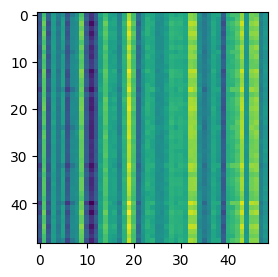

In [111]:
imshow(model.net.P.data.detach())

In [112]:
P = load_P_pred('4zhsjs98')

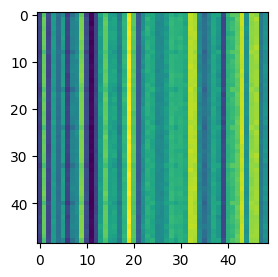

In [113]:
imshow(P)

In [114]:
size = np.prod(args.grid_size)
set_bias = args.bias
batch_size = args.batch_size

In [115]:
x, _, _ = batch = next(iter(datamodule.train_dataloader()))

In [116]:
def transform(x):
    return torch.roll(x, 1, 1)

In [126]:
type(implicit_statedict)

collections.OrderedDict

In [120]:
linear_p = LinearP(in_features=size, out_features=size, bias = set_bias, P_init = P)

linear_implicit = LinearImplicit(
    in_features = 7, 
    out_features = 7,
    bias = False,
    hidden_implicit_layers = [49, 49],
)
implicit_statedict = torch.load('../logs/store/implicit_P/be1v5f84.pt')
linear_implicit.implicit_P.load_state_dict(implicit_statedict)

# linear = linear_p
linear = linear_implicit

linear.eval()

LinearImplicit(
  (implicit_P): Sequential(
    (0): Linear(in_features=49, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=49, bias=True)
    (3): ReLU()
    (4): Linear(in_features=49, out_features=49, bias=True)
    (5): ReLU()
  )
)

In [121]:
linear_implicit.eval()
x_a = x
out_a = linear(x_a).detach()
out_a_prime = transform(out_a)

x_b = x
x_b_prime = transform(x_b)
out_b_prime = linear(x_b_prime).detach()

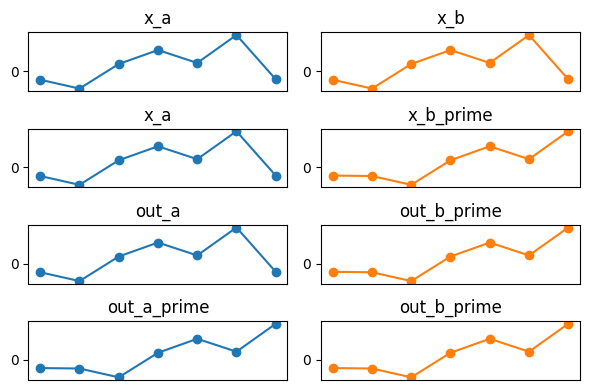

In [124]:
x_plots = [
    [x_a, x_b],
    [x_a, x_b_prime],
    [out_a, out_b_prime],
    [out_a_prime, out_b_prime],
]

x_titles = [
    ['x_a', 'x_b'],
    ['x_a', 'x_b_prime'],
    ['out_a', 'out_b_prime'],
    ['out_a_prime', 'out_b_prime'],
    ['out_a_prime_tilde', 'out_b_prime_tilde']
]

nrows = len(x_plots)

x_idx = np.random.randint(0, batch_size, 1)[0]
fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
for i, (x_l, x_r) in enumerate(x_plots):
    axs[i, 0].plot(x_l[x_idx].T, 'o-', color = 'tab:blue')
    axs[i, 0].set_title(x_titles[i][0])

    axs[i, 1].plot(x_r[x_idx].T, 'o-', color = 'tab:orange')
    axs[i, 1].set_title(x_titles[i][1])
    for ax in axs[i]:
        ax.set_xticks([])
        ax.set_yticks([0])
        # ax.axis('off')
plt.show()
plt.close()